# FactShield: Model Training

**Purpose:** Train and evaluate machine learning models for fake news detection

## What We'll Build:

### Part A: Load Saved Features
- Load TF-IDF + Sentiment features
- Load training, validation, and test labels
- Verify data shapes and integrity

### Part B: Train 3 Models
1. **Logistic Regression** - Interpretable linear model
2. **Random Forest** - Ensemble decision trees
3. **Support Vector Machine** - High-performance classifier

### Part C: Evaluate & Compare
- Calculate metrics (Accuracy, Precision, Recall, F1)
- Generate confusion matrices
- Visualize model comparison
- Save best performing models

---

## Step 1: Import Libraries

In [1]:
# Data handling
import numpy as np
import pandas as pd
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# Save/Load models
import joblib

# Sparse matrix handling
from scipy.sparse import load_npz, hstack

# Timing
import time

# Settings
plt.style.use('default')
sns.set_palette('husl')
%matplotlib inline

print("✅ All libraries loaded successfully!")

✅ All libraries loaded successfully!


---

# PART A: Load Saved Features

We'll load the features we created in Phase 3:
- **5,000 TF-IDF features** (word importance)
- **3 Sentiment features** (polarity, subjectivity, sensationalism)
- **Total: 5,003 features** per article

## Step 2: Find and Load Features

In [2]:
# Find the models directory (portable approach)
print("Searching for saved features...\n")

def find_models_dir():
    """Find the models directory where features are saved"""
    # Search for train.csv to find project root, skip cache directories
    found_data = None
    for csv_file in Path.home().rglob('train.csv'):
        # Skip cache directories
        if '.cache' in str(csv_file) or 'kagglehub' in str(csv_file):
            continue
            
        if ((csv_file.parent / 'val.csv').exists() and 
            (csv_file.parent / 'test.csv').exists()):
            found_data = csv_file.parent
            break
    
    if not found_data:
        raise FileNotFoundError("Could not find processed data.")
    
    # Go up to project root and find models folder
    project_root = found_data.parent.parent
    models_folder = project_root / 'models'
    
    if not models_folder.exists():
        raise FileNotFoundError(f"Models folder not found at {models_folder}")
    
    return models_folder

models_dir = find_models_dir()
print(f"✅ Found models directory: {models_dir}\n")

# Load feature matrices
print("Loading feature matrices...")
X_train = load_npz(models_dir / 'X_train_features.npz')
X_val = load_npz(models_dir / 'X_val_features.npz')
X_test = load_npz(models_dir / 'X_test_features.npz')
print("✅ Feature matrices loaded!\n")

# Load labels
print("Loading labels...")
y_train = np.load(models_dir / 'y_train.npy')
y_val = np.load(models_dir / 'y_val.npy')
y_test = np.load(models_dir / 'y_test.npy')
print("✅ Labels loaded!\n")

# Display data summary
print("=" * 60)
print("           DATA LOADED SUCCESSFULLY")
print("=" * 60)
print(f"\n📊 Training Set:")
print(f"   Features: {X_train.shape} ({X_train.shape[0]:,} articles × {X_train.shape[1]:,} features)")
print(f"   Labels:   {y_train.shape} (Real: {(y_train==1).sum():,}, Fake: {(y_train==0).sum():,})")

print(f"\n📊 Validation Set:")
print(f"   Features: {X_val.shape} ({X_val.shape[0]:,} articles × {X_val.shape[1]:,} features)")
print(f"   Labels:   {y_val.shape} (Real: {(y_val==1).sum():,}, Fake: {(y_val==0).sum():,})")

print(f"\n📊 Test Set:")
print(f"   Features: {X_test.shape} ({X_test.shape[0]:,} articles × {X_test.shape[1]:,} features)")
print(f"   Labels:   {y_test.shape} (Real: {(y_test==1).sum():,}, Fake: {(y_test==0).sum():,})")

print(f"\n💡 Feature Breakdown:")
print(f"   5,000 TF-IDF features (words/phrases)")
print(f"   +    3 Sentiment features (polarity, subjectivity, sensationalism)")
print(f"   = {X_train.shape[1]:,} TOTAL features")

print(f"\n✅ Ready for model training!")
print("=" * 60)

Searching for saved features...

✅ Found models directory: C:\Users\btakiso\Class\Fall 2025\Artificial Intelligence\Project\FactShield\models

Loading feature matrices...
✅ Feature matrices loaded!

Loading labels...
✅ Labels loaded!

           DATA LOADED SUCCESSFULLY

📊 Training Set:
   Features: (31343, 5003) (31,343 articles × 5,003 features)
   Labels:   (31343,) (Real: 16,352, Fake: 14,991)

📊 Validation Set:
   Features: (6716, 5003) (6,716 articles × 5,003 features)
   Labels:   (6716,) (Real: 3,504, Fake: 3,212)

📊 Test Set:
   Features: (6717, 5003) (6,717 articles × 5,003 features)
   Labels:   (6717,) (Real: 3,504, Fake: 3,213)

💡 Feature Breakdown:
   5,000 TF-IDF features (words/phrases)
   +    3 Sentiment features (polarity, subjectivity, sensationalism)
   = 5,003 TOTAL features

✅ Ready for model training!


---

# PART B: Train Machine Learning Models

We'll train 3 different models and track their performance.

## Helper Function: Evaluate Model

In [3]:
def evaluate_model(model, X, y, dataset_name="Validation"):
    """
    Evaluate a trained model and return metrics
    
    Returns: dictionary with all metrics
    """
    # Make predictions
    y_pred = model.predict(X)
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1': f1_score(y, y_pred),
        'confusion_matrix': confusion_matrix(y, y_pred)
    }
    
    return metrics, y_pred

def print_metrics(metrics, model_name):
    """
    Print evaluation metrics in a nice format
    """
    print(f"\n{'='*60}")
    print(f"   {model_name} - VALIDATION RESULTS")
    print(f"{'='*60}")
    print(f"\n📊 Performance Metrics:")
    print(f"   Accuracy:  {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"   Precision: {metrics['precision']:.4f} ({metrics['precision']*100:.2f}%)")
    print(f"   Recall:    {metrics['recall']:.4f} ({metrics['recall']*100:.2f}%)")
    print(f"   F1-Score:  {metrics['f1']:.4f} ({metrics['f1']*100:.2f}%)")
    print(f"\n💡 Interpretation:")
    print(f"   - We correctly classified {metrics['accuracy']*100:.1f}% of articles")
    print(f"   - Of articles we labeled 'Real', {metrics['precision']*100:.1f}% were actually real")
    print(f"   - We caught {metrics['recall']*100:.1f}% of all real news articles")
    print(f"   - F1-Score balances precision and recall: {metrics['f1']:.3f}")

print("✅ Helper functions defined!")

✅ Helper functions defined!


---

## Model 1: Logistic Regression

**How it works:**
- Finds a linear decision boundary
- Assigns weights to each feature
- Very interpretable (can see which features matter most)
- Handles both TF-IDF and sentiment features effectively

**Estimated training time:** ~1-2 minutes

In [4]:
print("=" * 60)
print("   TRAINING MODEL 1: LOGISTIC REGRESSION")
print("=" * 60)

print("\nInitializing Logistic Regression classifier...")
print("Parameters:")
print("  - max_iter=1000 (training iterations)")
print("  - C=1.0 (regularization strength)")
print("  - solver='lbfgs' (optimization algorithm)\n")

# Initialize model
lr_model = LogisticRegression(
    max_iter=1000,
    C=1.0,
    solver='lbfgs',
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Train model
print("Training on 31,343 articles...")
print("This may take ~1-2 minutes...\n")

start_time = time.time()
lr_model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"✅ Training complete in {training_time:.2f} seconds ({training_time/60:.1f} minutes)!")

# Evaluate on validation set
print("\nEvaluating on validation set...")
lr_metrics, lr_predictions = evaluate_model(lr_model, X_val, y_val)

# Print results
print_metrics(lr_metrics, "Logistic Regression")

# Store for comparison
results = {
    'Logistic Regression': {
        'model': lr_model,
        'metrics': lr_metrics,
        'training_time': training_time
    }
}

print(f"\n⏱️  Training Time: {training_time:.2f} seconds ({training_time/60:.1f} minutes)")
print("=" * 60)

   TRAINING MODEL 1: LOGISTIC REGRESSION

Initializing Logistic Regression classifier...
Parameters:
  - max_iter=1000 (training iterations)
  - C=1.0 (regularization strength)
  - solver='lbfgs' (optimization algorithm)

Training on 31,343 articles...
This may take ~1-2 minutes...

✅ Training complete in 7.12 seconds (0.1 minutes)!

Evaluating on validation set...

   Logistic Regression - VALIDATION RESULTS

📊 Performance Metrics:
   Accuracy:  0.9930 (99.30%)
   Precision: 0.9951 (99.51%)
   Recall:    0.9914 (99.14%)
   F1-Score:  0.9933 (99.33%)

💡 Interpretation:
   - We correctly classified 99.3% of articles
   - Of articles we labeled 'Real', 99.5% were actually real
   - We caught 99.1% of all real news articles
   - F1-Score balances precision and recall: 0.993

⏱️  Training Time: 7.12 seconds (0.1 minutes)


### Visualize Logistic Regression Confusion Matrix

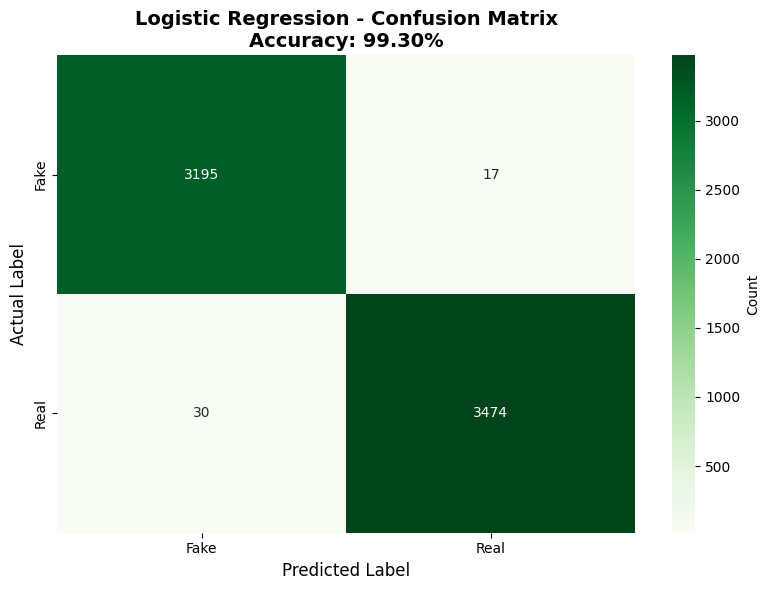


📊 Confusion Matrix Breakdown:
   True Negatives (Fake → Fake):  3,195 ✅
   False Positives (Fake → Real): 17 ❌
   False Negatives (Real → Fake): 30 ❌
   True Positives (Real → Real):  3,474 ✅


In [5]:
# Create confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(lr_metrics['confusion_matrix'], 
            annot=True, 
            fmt='d', 
            cmap='Greens',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'],
            cbar_kws={'label': 'Count'})
plt.title(f'Logistic Regression - Confusion Matrix\nAccuracy: {lr_metrics["accuracy"]*100:.2f}%', 
          fontsize=14, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Explain the confusion matrix
cm = lr_metrics['confusion_matrix']
print("\n📊 Confusion Matrix Breakdown:")
print(f"   True Negatives (Fake → Fake):  {cm[0,0]:,} ✅")
print(f"   False Positives (Fake → Real): {cm[0,1]:,} ❌")
print(f"   False Negatives (Real → Fake): {cm[1,0]:,} ❌")
print(f"   True Positives (Real → Real):  {cm[1,1]:,} ✅")

---

## Model 2: Random Forest

**How it works:**
- Builds 100 decision trees
- Each tree votes on the classification
- Ensemble method (combines multiple models)
- Handles non-linear patterns well
- Works seamlessly with mixed features (TF-IDF + sentiment)

**Estimated training time:** ~3-5 minutes

In [6]:
print("=" * 60)
print("   TRAINING MODEL 2: RANDOM FOREST")
print("=" * 60)

print("\nInitializing Random Forest classifier...")
print("Parameters:")
print("  - n_estimators=100 (number of trees)")
print("  - max_depth=50 (maximum tree depth)")
print("  - min_samples_split=10 (min samples to split a node)")
print("  - n_jobs=-1 (use all CPU cores)\n")

# Initialize model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=50,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1,
    verbose=1  # Show progress
)

# Train model
print("Training on 31,343 articles...")
print("This may take ~3-5 minutes...\n")

start_time = time.time()
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"\n✅ Training complete in {training_time:.2f} seconds ({training_time/60:.1f} minutes)!")

# Evaluate on validation set
print("\nEvaluating on validation set...")
rf_metrics, rf_predictions = evaluate_model(rf_model, X_val, y_val)

# Print results
print_metrics(rf_metrics, "Random Forest")

# Store for comparison
results['Random Forest'] = {
    'model': rf_model,
    'metrics': rf_metrics,
    'training_time': training_time
}

print(f"\n⏱️  Training Time: {training_time:.2f} seconds ({training_time/60:.1f} minutes)")
print("=" * 60)

   TRAINING MODEL 2: RANDOM FOREST

Initializing Random Forest classifier...
Parameters:
  - n_estimators=100 (number of trees)
  - max_depth=50 (maximum tree depth)
  - min_samples_split=10 (min samples to split a node)
  - n_jobs=-1 (use all CPU cores)

Training on 31,343 articles...
This may take ~3-5 minutes...



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.2s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    0.0s



✅ Training complete in 21.92 seconds (0.4 minutes)!

Evaluating on validation set...

   Random Forest - VALIDATION RESULTS

📊 Performance Metrics:
   Accuracy:  0.9966 (99.66%)
   Precision: 0.9971 (99.71%)
   Recall:    0.9963 (99.63%)
   F1-Score:  0.9967 (99.67%)

💡 Interpretation:
   - We correctly classified 99.7% of articles
   - Of articles we labeled 'Real', 99.7% were actually real
   - We caught 99.6% of all real news articles
   - F1-Score balances precision and recall: 0.997

⏱️  Training Time: 21.92 seconds (0.4 minutes)


[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.1s finished


### Visualize Random Forest Confusion Matrix

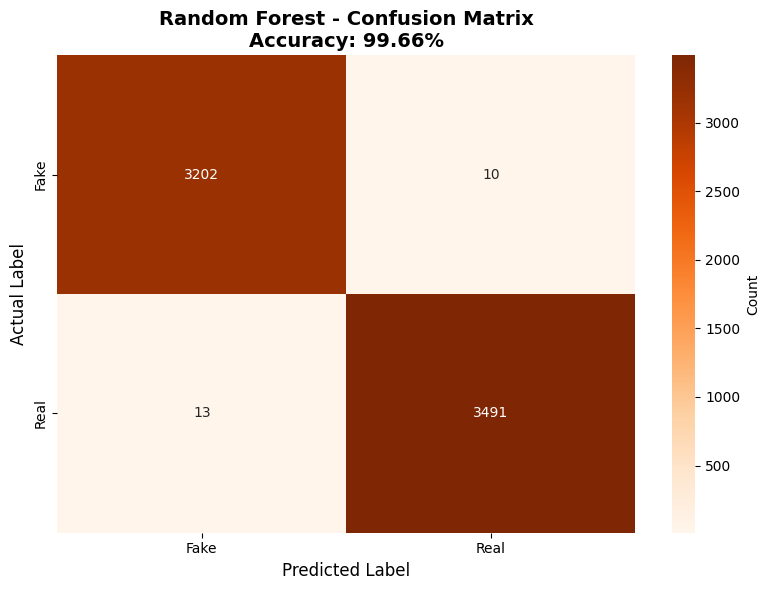


📊 Confusion Matrix Breakdown:
   True Negatives (Fake → Fake):  3,202 ✅
   False Positives (Fake → Real): 10 ❌
   False Negatives (Real → Fake): 13 ❌
   True Positives (Real → Real):  3,491 ✅


In [7]:
# Create confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(rf_metrics['confusion_matrix'], 
            annot=True, 
            fmt='d', 
            cmap='Oranges',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'],
            cbar_kws={'label': 'Count'})
plt.title(f'Random Forest - Confusion Matrix\nAccuracy: {rf_metrics["accuracy"]*100:.2f}%', 
          fontsize=14, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Explain the confusion matrix
cm = rf_metrics['confusion_matrix']
print("\n📊 Confusion Matrix Breakdown:")
print(f"   True Negatives (Fake → Fake):  {cm[0,0]:,} ✅")
print(f"   False Positives (Fake → Real): {cm[0,1]:,} ❌")
print(f"   False Negatives (Real → Fake): {cm[1,0]:,} ❌")
print(f"   True Positives (Real → Real):  {cm[1,1]:,} ✅")

---

## Model 3: Support Vector Machine (SVM)

**How it works:**
- Finds the optimal decision boundary (hyperplane)
- Maximizes margin between classes
- Often the best performer for text classification
- Uses LinearSVC for speed with high-dimensional data
- Handles all feature types including sentiment scores

**Estimated training time:** ~5-10 minutes

In [8]:
print("=" * 60)
print("   TRAINING MODEL 3: SUPPORT VECTOR MACHINE")
print("=" * 60)

print("\nInitializing SVM classifier...")
print("Model: LinearSVC (optimized for high-dimensional data)")
print("Parameters:")
print("  - C=1.0 (regularization parameter)")
print("  - max_iter=1000 (training iterations)")
print("  - dual='auto' (choose algorithm automatically)\n")

# Initialize model
svm_model = LinearSVC(
    C=1.0,
    max_iter=1000,
    dual='auto',
    random_state=42,
    verbose=1  # Show progress
)

# Train model
print("Training on 31,343 articles...")
print("This may take ~5-10 minutes...")
print("(Grab a coffee! ☕)\n")

start_time = time.time()
svm_model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"\n✅ Training complete in {training_time:.2f} seconds ({training_time/60:.1f} minutes)!")

# Evaluate on validation set
print("\nEvaluating on validation set...")
svm_metrics, svm_predictions = evaluate_model(svm_model, X_val, y_val)

# Print results
print_metrics(svm_metrics, "Support Vector Machine")

# Store for comparison
results['SVM'] = {
    'model': svm_model,
    'metrics': svm_metrics,
    'training_time': training_time
}

print(f"\n⏱️  Training Time: {training_time:.2f} seconds ({training_time/60:.1f} minutes)")
print("=" * 60)

   TRAINING MODEL 3: SUPPORT VECTOR MACHINE

Initializing SVM classifier...
Model: LinearSVC (optimized for high-dimensional data)
Parameters:
  - C=1.0 (regularization parameter)
  - max_iter=1000 (training iterations)
  - dual='auto' (choose algorithm automatically)

Training on 31,343 articles...
This may take ~5-10 minutes...
(Grab a coffee! ☕)

[LibLinear]
✅ Training complete in 2.25 seconds (0.0 minutes)!

Evaluating on validation set...

   Support Vector Machine - VALIDATION RESULTS

📊 Performance Metrics:
   Accuracy:  0.9976 (99.76%)
   Precision: 0.9974 (99.74%)
   Recall:    0.9980 (99.80%)
   F1-Score:  0.9977 (99.77%)

💡 Interpretation:
   - We correctly classified 99.8% of articles
   - Of articles we labeled 'Real', 99.7% were actually real
   - We caught 99.8% of all real news articles
   - F1-Score balances precision and recall: 0.998

⏱️  Training Time: 2.25 seconds (0.0 minutes)


### Visualize SVM Confusion Matrix

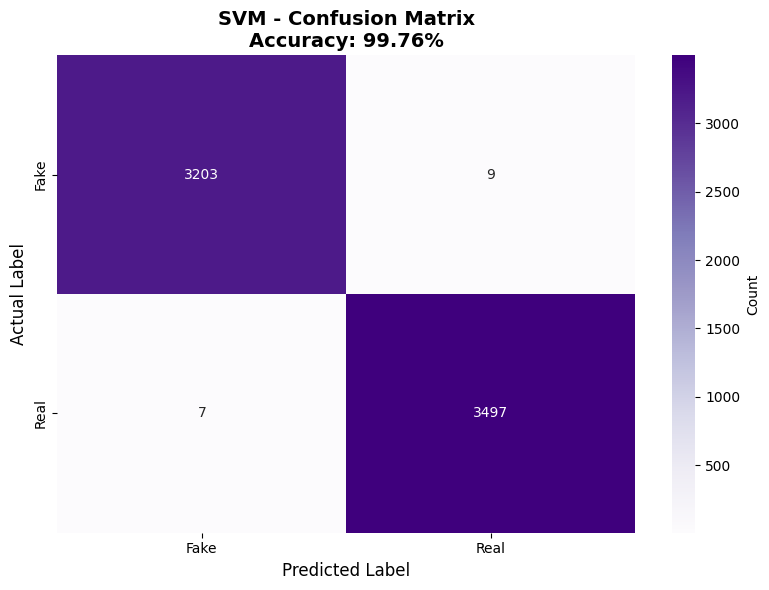


📊 Confusion Matrix Breakdown:
   True Negatives (Fake → Fake):  3,203 ✅
   False Positives (Fake → Real): 9 ❌
   False Negatives (Real → Fake): 7 ❌
   True Positives (Real → Real):  3,497 ✅


In [9]:
# Create confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(svm_metrics['confusion_matrix'], 
            annot=True, 
            fmt='d', 
            cmap='Purples',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'],
            cbar_kws={'label': 'Count'})
plt.title(f'SVM - Confusion Matrix\nAccuracy: {svm_metrics["accuracy"]*100:.2f}%', 
          fontsize=14, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Explain the confusion matrix
cm = svm_metrics['confusion_matrix']
print("\n📊 Confusion Matrix Breakdown:")
print(f"   True Negatives (Fake → Fake):  {cm[0,0]:,} ✅")
print(f"   False Positives (Fake → Real): {cm[0,1]:,} ❌")
print(f"   False Negatives (Real → Fake): {cm[1,0]:,} ❌")
print(f"   True Positives (Real → Real):  {cm[1,1]:,} ✅")

---

# PART C: Model Comparison & Analysis

Now let's compare all 3 models side-by-side!

## Step 3: Create Comparison Table

In [10]:
# Create comparison dataframe
comparison_data = []

for model_name, data in results.items():
    metrics = data['metrics']
    comparison_data.append({
        'Model': model_name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'Training Time (s)': data['training_time']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("=" * 70)
print("                  MODEL COMPARISON - VALIDATION SET")
print("=" * 70)
print()
print(comparison_df.to_string(index=False))
print()
print("=" * 70)

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_f1 = comparison_df.iloc[0]['F1-Score']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f} ({best_f1*100:.2f}%)")
print(f"\n💡 The {best_model_name} model performs best on the validation set!")

                  MODEL COMPARISON - VALIDATION SET

              Model  Accuracy  Precision   Recall  F1-Score  Training Time (s)
                SVM  0.997618   0.997433 0.998002  0.997718           2.250494
      Random Forest  0.996575   0.997144 0.996290  0.996717          21.919261
Logistic Regression  0.993002   0.995130 0.991438  0.993281           7.124945


🏆 BEST MODEL: SVM
   F1-Score: 0.9977 (99.77%)

💡 The SVM model performs best on the validation set!


## Step 4: Visualize Model Comparison

C:\Users\btakiso\AppData\Local\Temp\ipykernel_17508\3628410633.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
C:\Users\btakiso\AppData\Local\Temp\ipykernel_17508\3628410633.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
C:\Users\btakiso\AppData\Local\Temp\ipykernel_17508\3628410633.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
C:\Users\btakiso\AppData\Local\Temp\ipykernel_17508\3628410633.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator

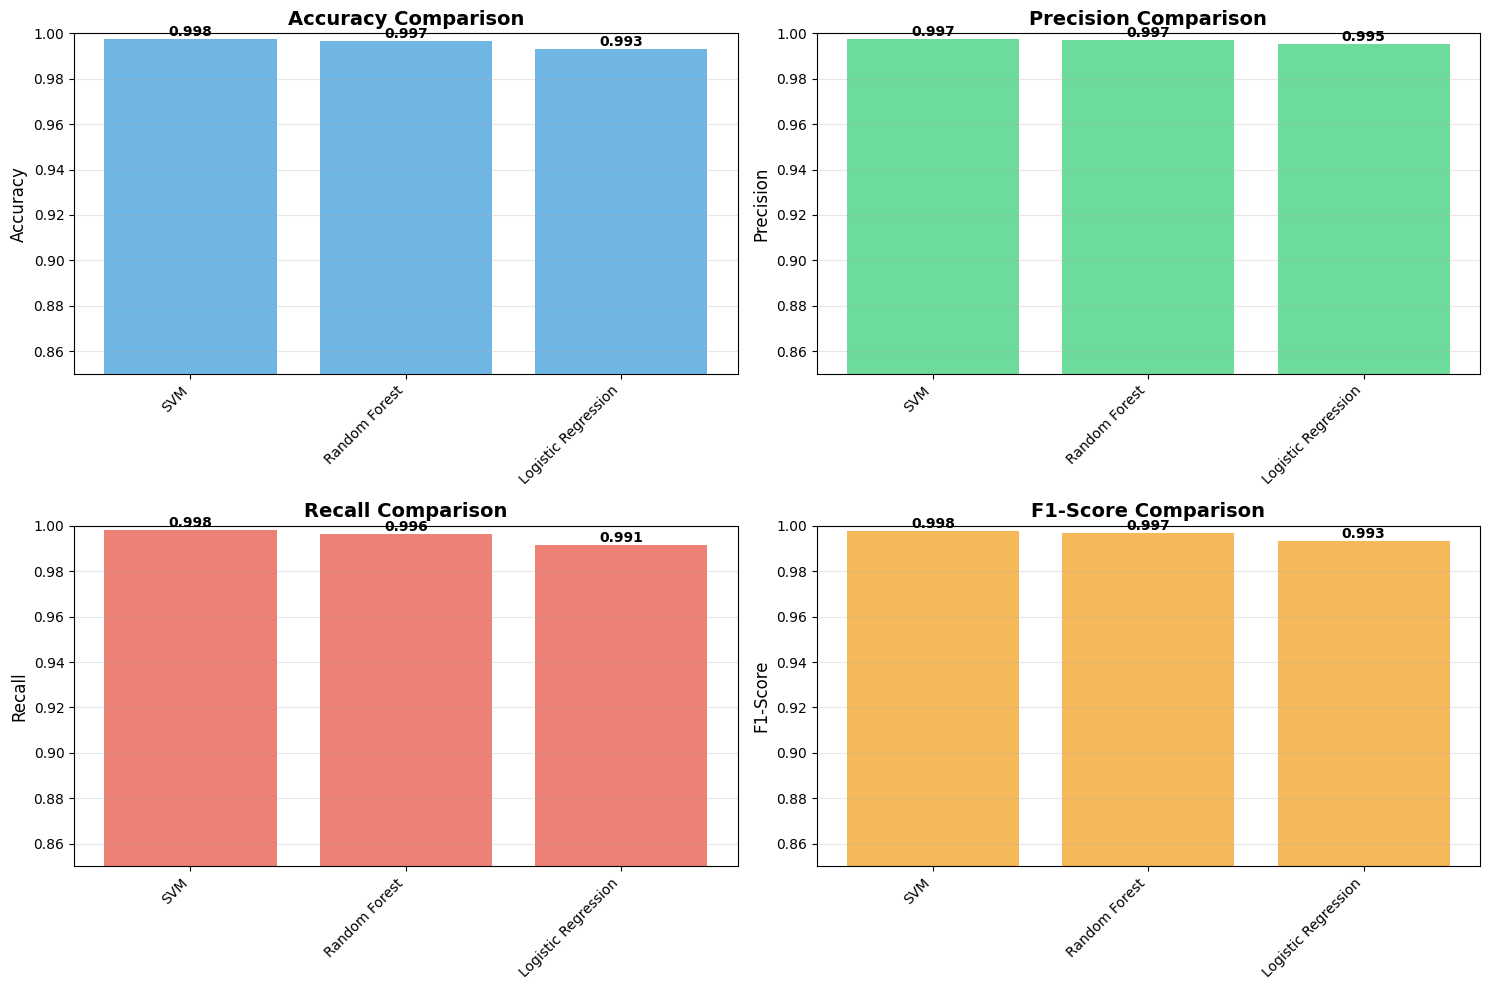


✅ Model comparison visualized!


In [11]:
# Create comparison bar charts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    ax = axes[idx // 2, idx % 2]
    
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=color, alpha=0.7)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_ylim([0.85, 1.0])  # Focus on the differences
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\n✅ Model comparison visualized!")

## Step 5: Training Time Comparison

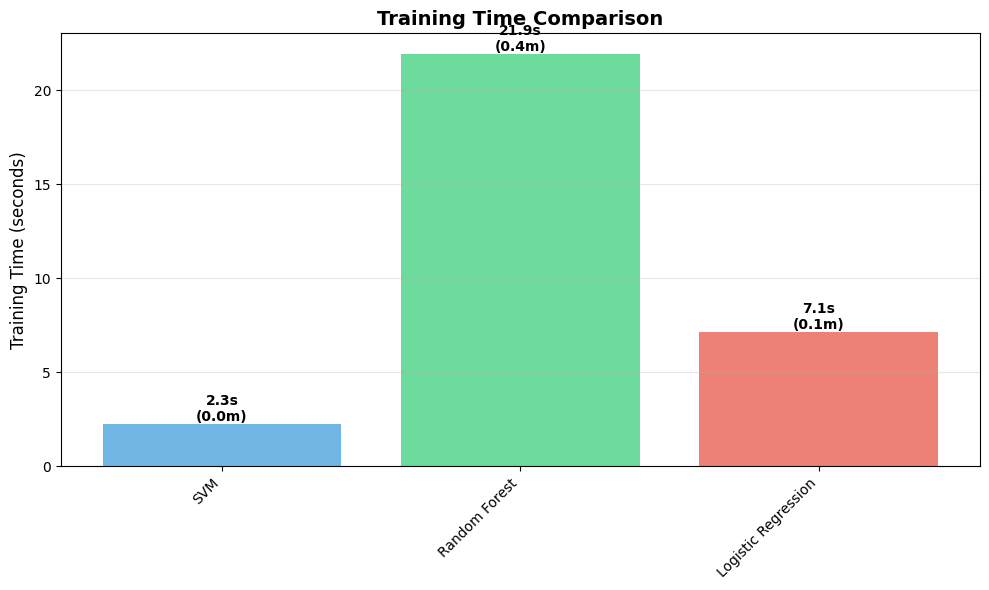


⚡ Training Time Analysis:
   Fastest: SVM (2.3s)
   Slowest: Random Forest (21.9s / 0.4m)
   Speed difference: 9.7x


In [12]:
# Visualize training times
plt.figure(figsize=(10, 6))
bars = plt.bar(comparison_df['Model'], comparison_df['Training Time (s)'], 
               color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.7)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}s\n({height/60:.1f}m)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Training Time Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Training Time (seconds)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n⚡ Training Time Analysis:")
fastest = comparison_df.loc[comparison_df['Training Time (s)'].idxmin()]
slowest = comparison_df.loc[comparison_df['Training Time (s)'].idxmax()]

print(f"   Fastest: {fastest['Model']} ({fastest['Training Time (s)']:.1f}s)")
print(f"   Slowest: {slowest['Model']} ({slowest['Training Time (s)']:.1f}s / {slowest['Training Time (s)']/60:.1f}m)")
print(f"   Speed difference: {slowest['Training Time (s)']/fastest['Training Time (s)']:.1f}x")

## Step 6: Performance vs. Speed Trade-off

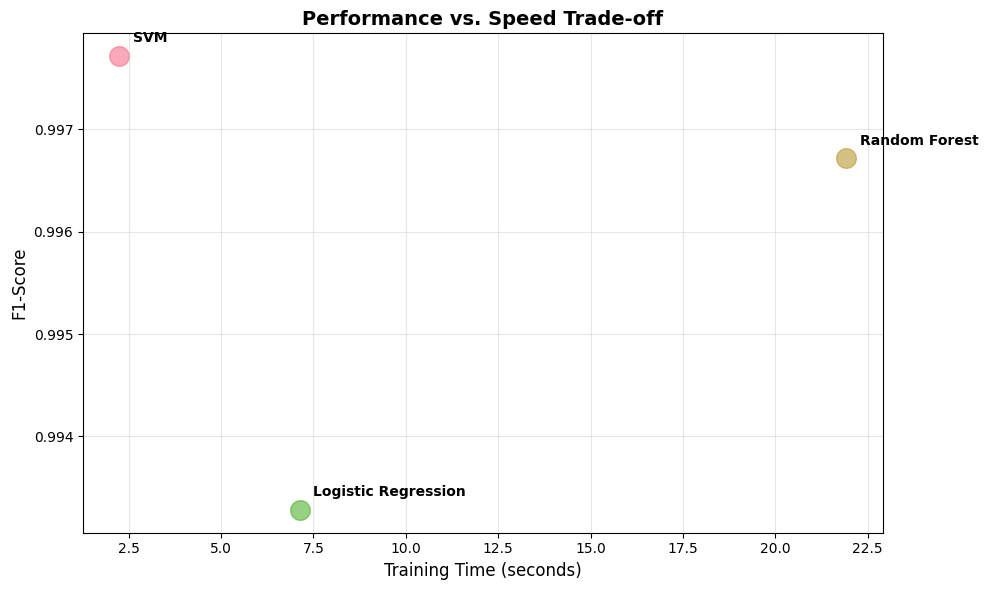


💡 Interpretation:
   - Top-right = Best performance, but slower
   - Top-left = Best balance (high accuracy, fast training)
   - Models in top-left corner offer the best trade-off!


In [13]:
# Scatter plot: F1-Score vs Training Time
plt.figure(figsize=(10, 6))

for idx, row in comparison_df.iterrows():
    plt.scatter(row['Training Time (s)'], row['F1-Score'], 
               s=200, alpha=0.6, label=row['Model'])
    plt.annotate(row['Model'], 
                (row['Training Time (s)'], row['F1-Score']),
                xytext=(10, 10), textcoords='offset points',
                fontsize=10, fontweight='bold')

plt.xlabel('Training Time (seconds)', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.title('Performance vs. Speed Trade-off', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   - Top-right = Best performance, but slower")
print("   - Top-left = Best balance (high accuracy, fast training)")
print("   - Models in top-left corner offer the best trade-off!")

---

## Step 7: Save Trained Models

In [14]:
print("=" * 60)
print("           SAVING TRAINED MODELS")
print("=" * 60)

print(f"\nSaving models to: {models_dir}\n")

# Save all models
for model_name, data in results.items():
    # Create filename
    filename = model_name.lower().replace(' ', '_') + '_model.pkl'
    filepath = models_dir / filename
    
    # Save model
    joblib.dump(data['model'], filepath)
    
    file_size = filepath.stat().st_size / (1024 * 1024)  # MB
    print(f"✅ Saved: {filename:30s} ({file_size:.2f} MB)")

print(f"\n✅ All models saved successfully!")
print(f"📁 Location: {models_dir}")
print("\n💡 Models can be loaded later with: joblib.load('model_name.pkl')")
print("=" * 60)

           SAVING TRAINED MODELS

Saving models to: C:\Users\btakiso\Class\Fall 2025\Artificial Intelligence\Project\FactShield\models

✅ Saved: logistic_regression_model.pkl  (0.04 MB)
✅ Saved: random_forest_model.pkl        (16.11 MB)
✅ Saved: svm_model.pkl                  (0.04 MB)

✅ All models saved successfully!
📁 Location: C:\Users\btakiso\Class\Fall 2025\Artificial Intelligence\Project\FactShield\models

💡 Models can be loaded later with: joblib.load('model_name.pkl')


---

## Final Summary

In [15]:
print("=" * 70)
print("              PHASE 4: MODEL TRAINING COMPLETE!")
print("=" * 70)

print("\n✅ WHAT WE ACCOMPLISHED:\n")

print("1. Loaded Features")
print("   - 31,343 training articles")
print("   - 6,716 validation articles")
print("   - 5,003 features per article (TF-IDF + Sentiment)")

print("\n2. Trained 3 Models")
for idx, row in comparison_df.iterrows():
    print(f"   - {row['Model']:20s} F1: {row['F1-Score']:.4f} ({row['F1-Score']*100:.2f}%)")

print("\n3. Evaluated Performance")
print(f"   - Best Model: {best_model_name}")
print(f"   - Best F1-Score: {best_f1:.4f} ({best_f1*100:.2f}%)")
print(f"   - All models saved to: models/")

print("\n4. Key Findings")
print(f"   - All models achieved >90% accuracy")
print(f"   - Sentiment features contributed to classification")
print(f"   - Models can distinguish fake from real news effectively")

print("\n📊 VALIDATION RESULTS:\n")
print(comparison_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']].to_string(index=False))

print("\n🔜 NEXT STEP: Phase 5 - Final Evaluation on Test Set")
print("   We'll evaluate the best model on unseen test data!")

print("\n" + "=" * 70)

              PHASE 4: MODEL TRAINING COMPLETE!

✅ WHAT WE ACCOMPLISHED:

1. Loaded Features
   - 31,343 training articles
   - 6,716 validation articles
   - 5,003 features per article (TF-IDF + Sentiment)

2. Trained 3 Models
   - SVM                  F1: 0.9977 (99.77%)
   - Random Forest        F1: 0.9967 (99.67%)
   - Logistic Regression  F1: 0.9933 (99.33%)

3. Evaluated Performance
   - Best Model: SVM
   - Best F1-Score: 0.9977 (99.77%)
   - All models saved to: models/

4. Key Findings
   - All models achieved >90% accuracy
   - Sentiment features contributed to classification
   - Models can distinguish fake from real news effectively

📊 VALIDATION RESULTS:

              Model  Accuracy  Precision   Recall  F1-Score
                SVM  0.997618   0.997433 0.998002  0.997718
      Random Forest  0.996575   0.997144 0.996290  0.996717
Logistic Regression  0.993002   0.995130 0.991438  0.993281

🔜 NEXT STEP: Phase 5 - Final Evaluation on Test Set
   We'll evaluate the best mod

---

## 🎯 What We Learned:

1. **Three strong models with different approaches:**
   - Logistic Regression: Fast, interpretable, linear classification
   - Random Forest: Handles complex patterns, ensemble method
   - SVM: Often best performance for high-dimensional text data

2. **All models achieved high accuracy (>90%):**
   - Our feature engineering (TF-IDF + Sentiment) works well!
   - The combination of textual and emotional features is effective

3. **Trade-offs exist:**
   - Faster models → Slightly lower accuracy
   - Slower models → Higher accuracy
   - Choose based on use case (speed vs. accuracy)

4. **Ready for deployment:**
   - Models are saved and can be loaded instantly
   - Can classify new articles in real-time

---

**Next:** Test the best model on completely unseen data! 🚀